In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Auto_Encoder(nn.Module):
    def __init__(self,nb_channels,img_size = (32,32,32)):
        nn.Module.__init__(self)
        self.nb_channels = nb_channels
        self.img_size = img_size
        self.pool = nn.MaxPool3d(kernel_size = 2,return_indices = True)
        self.unpool = nn.MaxUnpool3d(kernel_size = 2)
        self.conv1 = nn.Conv3d(in_channels = nb_channels, out_channels = 8 , kernel_size = 3 , padding = 1)
        self.conv2 = nn.Conv3d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.deconv1 = nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv2 = nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, padding = 1)
        self.deconv3 = nn.Conv3d(in_channels = 8, out_channels = nb_channels, kernel_size = 3, padding = 1)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x,indices1 = self.pool(x)
        x = F.relu(self.conv2(x))
        x,indices2 = self.pool(x)
        x = F.relu(self.conv3(x))
        x,indices3 = self.pool(x)
        encoded = x
        x = self.unpool(x,indices3)
        x = F.relu(self.deconv1(x))
        x = self.unpool(x,indices2)
        x = F.relu(self.deconv2(x))
        x = self.unpool(x,indices1)
        x = self.deconv3(x)
        decoded = x
        return x

In [3]:
def train_AE(AE,epochs = 501, batch_size = 4):
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(AE.parameters())
    start_time = datetime.datetime.now()
    losses = []
    torch.set_num_threads(8)
    for epoch in range(epochs):
        #load data
        N_train = 0.5 * len(os.listdir('Euler_Displacement'))
        inputs = np.zeros((batch_size,) + (AE.nb_channels,) + AE.img_size)
        for i in range(batch_size):
            idx = np.random.randint(0,N_train)
            img = np.load('Euler_Displacement/' + os.listdir('Euler_Displacement')[idx])
            #img = img.reshape((AE.nb_channels,) + AE.img_size)
            x = np.random.randint(0,256-AE.img_size[0])
            patch = img[x:x+AE.img_size[0],x:x+AE.img_size[1],x:x+AE.img_size[2]]
            patch = patch.reshape((AE.nb_channels,) + AE.img_size)
            inputs[i] = patch
        
        inputs = torch.Tensor(inputs)
        #Gradient set to zero
        optimizer.zero_grad()
        
        # forward + backward 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #print(device)
        AE = AE.to(device)
        inputs = inputs.to(device)
        outputs = AE(inputs)
        loss = criterion(outputs, inputs)
        loss.backward() 
        
        #update parameters
        optimizer.step()
        
        losses.append(loss.item())
        if(epoch%10 ==0):
            print(loss.item())
            print(datetime.datetime.now() - start_time)
    
    np.save('history.npy',np.array(losses))
    return AE

In [4]:
AE = Auto_Encoder(nb_channels = 1)

In [5]:
AE = train_AE(AE)

97.37346649169922
0:00:06.256795
69.44392395019531
0:00:10.708055
39.229339599609375
0:00:14.963295
37.97355651855469
0:00:18.571390
1.164306402206421
0:00:22.148854
19.83287811279297
0:00:25.897851
32.39992904663086
0:00:29.590840
12.785661697387695
0:00:33.150998
17.900243759155273
0:00:36.854088
3.4264020919799805
0:00:40.798647
34.693572998046875
0:00:44.791180
13.064411163330078
0:00:48.457721
4.049027442932129
0:00:52.061968
9.605369567871094
0:00:55.931942
12.303120613098145
0:00:59.872618
21.401262283325195
0:01:03.557525
11.169468879699707
0:01:07.075117
6.518003463745117
0:01:11.589474
4.4902472496032715
0:01:15.549598
3.408803939819336
0:01:18.541236
8.211265563964844
0:01:21.504999
4.501715660095215
0:01:24.564291
3.74326753616333
0:01:27.621628
5.00960636138916
0:01:30.604151
3.881869077682495
0:01:33.586283
4.777606964111328
0:01:36.781657
5.2226386070251465
0:01:39.747205
2.494910478591919
0:01:42.728843
11.16810417175293
0:01:45.740967
10.87783432006836
0:01:48.756828
3

In [6]:
history = np.load('history.npy')

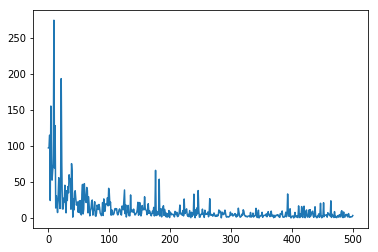

In [7]:
plt.plot(history)

In [8]:
testset = []
for idx in range(110,190):
    img = np.load('Euler_Displacement/' + os.listdir('Euler_Displacement')[idx])
    x = np.random.randint(0,192)
    patch = img[x:x+64,x:x+64,x:x+64]
    testset.append(patch)

In [9]:
testinput = np.array(testset)
testinput = testinput.reshape((testinput.shape[0],1,64,64,64))
testinput = torch.Tensor(testinput)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testinput = testinput.to(device)
testoutput = AE(testinput)
criterion = nn.MSELoss()
loss = criterion(testoutput, testinput)
print(loss)

tensor(6.6936, device='cuda:0', grad_fn=<MseLossBackward>)
